In [ ]:
!pip install validators
!pip install torch torchvision torchaudio
!pip install wget
%pip uninstall --yes torch torchvision torchaudio
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
%pip install torchinfo

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')


Using cuda for inference


In [2]:
torch.cuda.is_available()

True

In [3]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

resnet50.fc = nn.Sequential(
               nn.Linear(2048, 36),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(36, 36),
               nn.Softmax()).to(device)                                             

torch.autograd.set_detect_anomaly(True)   

In [5]:
#DATADIR = "BeeMachine_quarter"
DATADIR = "C:/Users/drago/Documents/2022 CIS 732/Project/Cropped_Bombus/Bumble_iNat_BugGuide_BBW_BBB"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

In [6]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys


In [7]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [8]:
import os

dataset = {}

def create_dataset():
    image_cap = 400
    for category in CATEGORIES:
        img_filenames = []
        path = os.path.join(DATADIR,category)
        cnt = 0  
        for img in os.listdir(path):
            try:
                img_filenames.append(os.path.join(path,img))
                cnt = cnt + 1
            except Exception as e:
                pass
            if cnt >= image_cap:
                break
        dataset[category] = img_filenames
        
create_dataset()

In [9]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(DATADIR + '\\train', data_transforms['train']),
    
    'validation': 
    datasets.ImageFolder(DATADIR + '\\validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
      
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}


In [10]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def process(train_loader, test_loader):
    
    model = torchvision.models.__dict__[args.arch]()
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()
       # model = torch.nn.DataParallel(model).to(device)

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders['train']):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in dataloaders['validation']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(dataloaders['validation'])
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch)
        train(dataloaders['train'])
        test_acc, confusion_mtx = test(dataloaders['validation'])
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
    vis(test_accs, confusion_mtxes, classe_labels)

Dataset: 339 training samples & 85 testing samples

Distribution of classes in dataset:


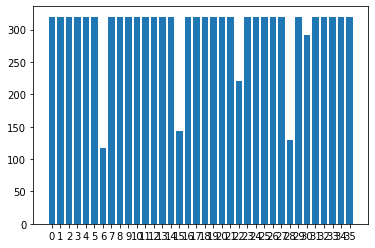

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
        
#!pip install seaborn
import seaborn as sns

print('Dataset: %d training samples & %d testing samples\n' % (
    len(dataloaders['train']), len(dataloaders['validation'])))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in image_datasets['train']]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [12]:
from typing import Callable

import pandas as pd
import torch
import torch.utils.data
import torchvision
import pytorch_resample


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())
        
    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataloaders)
        #elif isinstance(dataset, torchvision.datasets.MNIST):
        elif isinstance(dataset, torch.utils.data.DataLoader):
    
            return dataset.train_labels.tolist()
        elif isinstance(dataset, datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torch.utils.data.DataLoader):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError



    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
    

In [13]:
sample = pytorch_resample.OverSampler(
dataset=dataset,
desired_dist={0: .33, 1: .33, 2: .33},seed=42)

In [14]:
isinstance(sample, torch.utils.data.IterableDataset)

True

In [ ]:
process(dataloaders['train'], dataloaders['validation'])


Best test acc = 1915.29%

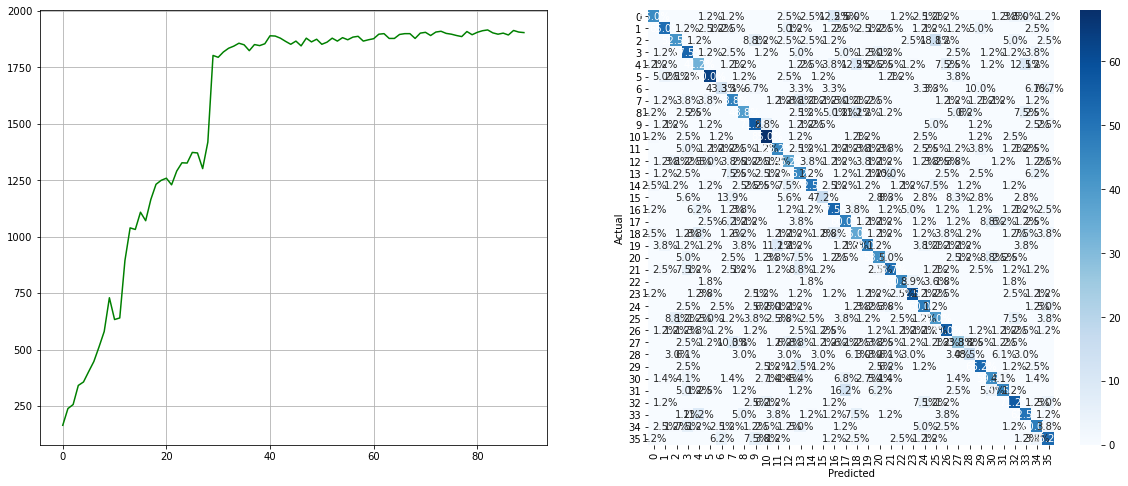

In [15]:
process(torch.utils.data.DataLoader(image_datasets['train'],batch_size=args.batch_size, 
    sampler=ImbalancedDatasetSampler(image_datasets['train']),
    **kwargs), dataloaders['validation'])

In [4]:
import torch
print(torch.__version__)

1.11.0+cpu


In [6]:
print(torch.version.cuda) 

None
